In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/data-science-bowl-2018/stage1_test.zip
/kaggle/input/data-science-bowl-2018/stage1_sample_submission.csv.zip
/kaggle/input/data-science-bowl-2018/stage2_sample_submission_final.csv.zip
/kaggle/input/data-science-bowl-2018/stage1_train.zip
/kaggle/input/data-science-bowl-2018/stage1_train_labels.csv.zip
/kaggle/input/data-science-bowl-2018/stage1_solution.csv.zip
/kaggle/input/data-science-bowl-2018/stage2_test_final.zip


In [3]:
from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))

data-science-bowl-2018



In [4]:
from zipfile import ZipFile
with ZipFile("../input/data-science-bowl-2018/stage1_train.zip","r") as zip_ref:
    zip_ref.extractall("./stage1_train")
    
with ZipFile("../input/data-science-bowl-2018/stage1_test.zip","r") as zip_ref:
    zip_ref.extractall("./stage1_test")

# 의학적 발견을 발전시키기 위해 다양한 이미지에서 세포핵 찾기 대회
목표: 이미지의 세포핵을 자동으로 인식할 수 있는 컴퓨터 모델을 만드는 것. 패턴을 관찰하고 모델을 구축.

In [5]:
import pathlib
import imageio
import numpy as np

training_paths = pathlib.Path('stage1_train').glob('*/images/*.png')

In [6]:
training_paths

<generator object Path.glob at 0x797474fda880>

In [7]:
training_sorted = sorted([x for x in training_paths])

#파일 정렬 이유
##학습 데이터를 순서대로 처리하면서 샘플들을 일괄적으로 로딩하고 처리할 수 있음. 
##정렬된 순서로 처리하면 예측 가능한 순서로 처리할 수 있어서 디버깅에 유용

In [8]:
training_sorted[45]

PosixPath('stage1_train/10ba6cbee4873b32d5626a118a339832ba2b15d8643f66dddcd7cb2ec80fbc28/images/10ba6cbee4873b32d5626a118a339832ba2b15d8643f66dddcd7cb2ec80fbc28.png')

In [9]:
im_path = training_sorted[45]
im_path

PosixPath('stage1_train/10ba6cbee4873b32d5626a118a339832ba2b15d8643f66dddcd7cb2ec80fbc28/images/10ba6cbee4873b32d5626a118a339832ba2b15d8643f66dddcd7cb2ec80fbc28.png')

In [10]:
#imageio.imread() - 이미지 파일을 numpy형태로 변환
im = imageio.imread(str(im_path))
im

/tmp/ipykernel_34/354678727.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  im = imageio.imread(str(im_path))


Array([[[  3,   3,   3, 255],
        [  3,   3,   3, 255],
        [  7,   7,   7, 255],
        ...,
        [  1,   1,   1, 255],
        [  1,   1,   1, 255],
        [  1,   1,   1, 255]],

       [[  3,   3,   3, 255],
        [  6,   6,   6, 255],
        [ 13,  13,  13, 255],
        ...,
        [  1,   1,   1, 255],
        [  1,   1,   1, 255],
        [  1,   1,   1, 255]],

       [[  4,   4,   4, 255],
        [ 11,  11,  11, 255],
        [ 17,  17,  17, 255],
        ...,
        [  1,   1,   1, 255],
        [  1,   1,   1, 255],
        [  1,   1,   1, 255]],

       ...,

       [[ 45,  45,  45, 255],
        [ 45,  45,  45, 255],
        [ 43,  43,  43, 255],
        ...,
        [  2,   2,   2, 255],
        [  2,   2,   2, 255],
        [  2,   2,   2, 255]],

       [[ 45,  45,  45, 255],
        [ 45,  45,  45, 255],
        [ 43,  43,  43, 255],
        ...,
        [  2,   2,   2, 255],
        [  2,   2,   2, 255],
        [  2,   2,   2, 255]],

       [[ 41

### Dealing with color(색상다루기)
이 데이터 세트의 이미지는 획득한 "양식"에 따라 RGB, RGBA 및 회색조 형식일 수 있습니다. 컬러 이미지의 경우 "채널"을 인코딩하는 세 개의 차원(예: 빨강, 녹색, 파랑)이 있습니다. 이 첫 번째 패스를 더 간단하게 만들기 위해 scikit-image의 rgb2gray 함수를 사용하여 이러한 모든 이미지를 그레이스케일로 강제 변환할 수 있습니다.

**결론) 다양한 형식의 이미지 파일이 있는데, 여기서는 모두 그레이스케일로 변환**

In [11]:
#이미지의 차원 출력
print('Original image shape: {}'.format(im.shape))

Original image shape: (520, 696, 4)


* 불투명도가 추가된 RGBA 형식의 파일이 있음(4차원)
* RGBA에서 마지막 불투명도차원을 제거(im = im[..., :3])
* if 3차원(;RGB파일) 중에서 마지막 차원의 크기가 4인 파일 조건문

In [12]:
#이미지 grayscale로 변환
from skimage.color import rgb2gray
im = imageio.imread(str(im_path))
if im.ndim == 3 and im.shape[-1] == 4:
    im = im[..., :3]
im_gray = rgb2gray(im)
print('New image shape: {}'.format(im_gray.shape))

New image shape: (520, 696)


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/tmp/ipykernel_34/1810277356.py:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  im = imageio.imread(str(im_path))


In [60]:
im_gray

array([[0.01176471, 0.01176471, 0.02745098, ..., 0.00392157, 0.00392157, 0.00392157],
       [0.01176471, 0.02352941, 0.05098039, ..., 0.00392157, 0.00392157, 0.00392157],
       [0.01568627, 0.04313725, 0.06666667, ..., 0.00392157, 0.00392157, 0.00392157],
       ...,
       [0.17647059, 0.17647059, 0.16862745, ..., 0.00784314, 0.00784314, 0.00784314],
       [0.17647059, 0.17647059, 0.16862745, ..., 0.00784314, 0.00784314, 0.00784314],
       [0.16078431, 0.17254902, 0.17647059, ..., 0.00784314, 0.00784314, 0.00784314]])

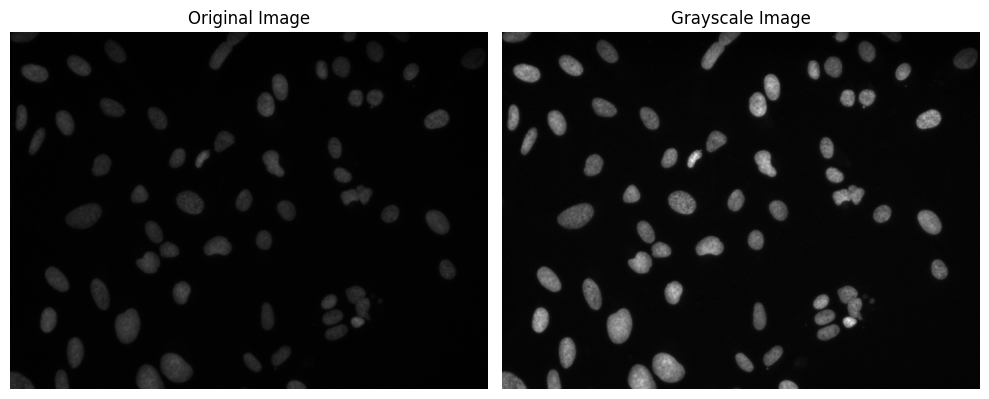

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.imshow(im)
plt.axis('off')
plt.title('Original Image')

plt.subplot(1,2,2)
plt.imshow(im_gray, cmap='gray')
plt.axis('off')
plt.title('Grayscale Image')

plt.tight_layout()
plt.show()

### Removing background(백그라운드 제거하기)
이 문제에 대해 가장 간단한 접근 방법은 이미지에 물체와 배경 두 가지 클래스가 있다고 가정하는 것입니다. 이 가정 하에, 우리는 강도의 이진 분포로 데이터가 나뉘어질 것으로 기대합니다. 우리가 최선의 분리 값을 찾으면, 우리는 배경 데이터를 "마스킹"하고 남은 물체를 세기만 하면 됩니다.

임계값을 찾는 가장 "어리석은" 방법은 평균이나 중간값과 같은 간단한 기술적 통계를 사용하는 것입니다. 그러나 다른 방법도 있습니다. "Otsu" 방법은 이미지를 이진 분포로 모델링하고 최적 분리 값을 찾는 데 유용합니다.


**결론) 관심 대상의 물체와 배경을 분리하는 최적의 값을 찾는다면 배경을 마스크 할 수 있으며 관심 객체를 처리하기 쉬워짐. 기술적 통계 방식 말고 Otsu 방식을 사용해 최적 분리값을 찾아낼 예정**

In [14]:
im_gray  #이 형태의 파일을 이진분류할때, 최적의 임계값을 찾아줄 것

array([[0.01176471, 0.01176471, 0.02745098, ..., 0.00392157, 0.00392157,
        0.00392157],
       [0.01176471, 0.02352941, 0.05098039, ..., 0.00392157, 0.00392157,
        0.00392157],
       [0.01568627, 0.04313725, 0.06666667, ..., 0.00392157, 0.00392157,
        0.00392157],
       ...,
       [0.17647059, 0.17647059, 0.16862745, ..., 0.00784314, 0.00784314,
        0.00784314],
       [0.17647059, 0.17647059, 0.16862745, ..., 0.00784314, 0.00784314,
        0.00784314],
       [0.16078431, 0.17254902, 0.17647059, ..., 0.00784314, 0.00784314,
        0.00784314]])

In [15]:
from skimage.filters import threshold_otsu
thresh_val = threshold_otsu(im_gray)
thresh_val #임계값

0.08195465686274508

In [16]:
#np.where: 조건을 기준으로 해당되면 1, 아니면 0
#물체를 나타내는 픽셀이 1. 배경이 0
mask = np.where(im_gray > thresh_val, 1, 0)
mask

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])

**마스크 작업은 우리가 중요하게 생각하는 부분을 추출하는 것. 근데 배경이 더 많이 된 경우, 이후의 처리에서 배경이 더 중요하게 여겨질 수 있음(물체가 차지하는 비율이 높을수록 마스크 처리 후에 물체 영역이 더 잘 보존) => 따라서 이런 경우 0과 1을 반전시켜줘야 좋음**

In [17]:
if np.sum(mask==0) < np.sum(mask==1):
    mask = np.where(mask, 0, 1)

In [18]:
print(np.sum(mask==0))
print(np.sum(mask==1))
mask

322049
39871


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])

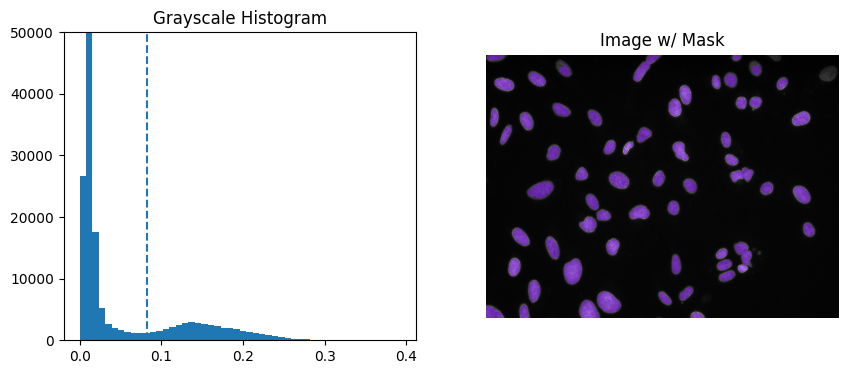

In [19]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
im_pixels = im_gray.flatten()
plt.hist(im_pixels,bins=50)
plt.vlines(thresh_val, 0, 100000, linestyle='--')
plt.ylim([0,50000])
plt.title('Grayscale Histogram')

plt.subplot(1,2,2)
mask_for_display = np.where(mask, mask, np.nan) #1(true)면 1 유지, 0(false)면 nan 값 채우기
plt.imshow(im_gray, cmap='gray')
plt.imshow(mask_for_display, cmap = 'rainbow', alpha = 0.5)#낮은 값은 붉은색에 가깝고 높은 값은 보라색에 가깝게 매핑. 1이라서 보라색 마스킹 출력
plt.axis('off')
plt.title('Image w/ Mask')

plt.show()

### Deriving individual masks for each object(개별 물체에 대한 개별 마스크를 생성)
세포핵의 각각에 대한 분리된 마스크를 얻기 위해, 연결된 모든 물체를 마스크에서 찾아서 ndimage.label을 사용하여 각각의 레이블 ID를 할당하고, 이 ID를 리스트와 같은 반복 가능한 객체에 추가할 수 있습니다. 이렇게 하면 각 레이블 ID에 해당하는 개별 물체의 마스크를 생성할 수 있습니다.

**결론) 각 이미지에 있는 객체들에 대하여 개별적인 마스크를 생성 및 추출**

In [21]:
mask

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])

In [20]:
from scipy import ndimage
labels, nlabels = ndimage.label(mask)

label_arrays = []
for label_num in range(1, nlabels+1):
    label_mask = np.where(labels == label_num, 1, 0)
    label_arrays.append(label_mask)

print('There are {} separate components / objects detected.'.format(nlabels))

There are 76 separate components / objects detected.


In [26]:
labels

array([[ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       ...,
       [75, 75, 75, ...,  0,  0,  0],
       [75, 75, 75, ...,  0,  0,  0],
       [75, 75, 75, ...,  0,  0,  0]], dtype=int32)

In [23]:
nlabels

76

In [39]:
import sys

import numpy as np

np.set_printoptions(threshold=6, linewidth = 100)

In [41]:
labels

array([[ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       ...,
       [75, 75, 75, ...,  0,  0,  0],
       [75, 75, 75, ...,  0,  0,  0],
       [75, 75, 75, ...,  0,  0,  0]], dtype=int32)

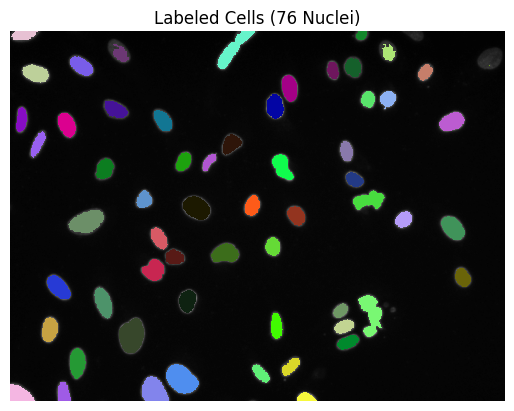

In [42]:
from matplotlib.colors import ListedColormap
rand_cmap = ListedColormap(np.random.rand(256,3))

labels_for_display = np.where(labels > 0, labels, np.nan)
plt.imshow(im_gray, cmap='gray')
plt.imshow(labels_for_display, cmap=rand_cmap)
plt.axis('off')
plt.title('Labeled Cells ({} Nuclei)'.format(nlabels))
plt.show()

간단한 이미지에서 두 가지 문제가 발견됩니다:

* 몇 개의 독립된 픽셀이 있습니다(예: 오른쪽 상단).
* 일부 세포가 하나의 마스크로 결합됩니다(예: 상단 중앙).

ndimage.find_objects를 사용하여 우리의 마스크를 반복하면서 개별 핵을 확대하고 추가 처리 단계를 적용할 수 있습니다. find_objects는 이미지에서 레이블링된 개체의 각 좌표 범위의 목록을 반환합니다.

In [45]:
ndimage.find_objects(labels)
#(slice(0, 14, None), slice(1, 40, None)) => y좌표가 0에서 14까지, x좌표가 1에서 40까지인 영역
## 객체에 대하여 바운딩 박스를 그릴 수 있음
## 객체 탐지 가능

[(slice(0, 14, None), slice(1, 40, None)),
 (slice(0, 55, None), slice(290, 347, None)),
 (slice(0, 14, None), slice(485, 503, None)),
 (slice(16, 45, None), slice(141, 169, None)),
 (slice(16, 17, None), slice(527, 528, None)),
 (slice(16, 17, None), slice(529, 530, None)),
 (slice(17, 43, None), slice(521, 543, None)),
 (slice(17, 18, None), slice(530, 531, None)),
 (slice(18, 20, None), slice(140, 142, None)),
 (slice(23, 24, None), slice(143, 144, None)),
 (slice(24, 25, None), slice(141, 142, None)),
 (slice(34, 64, None), slice(83, 118, None)),
 (slice(37, 66, None), slice(469, 495, None)),
 (slice(41, 69, None), slice(445, 463, None)),
 (slice(41, 43, None), slice(665, 668, None)),
 (slice(44, 45, None), slice(661, 664, None)),
 (slice(44, 47, None), slice(670, 672, None)),
 (slice(46, 74, None), slice(16, 56, None)),
 (slice(46, 71, None), slice(573, 595, None)),
 (slice(46, 47, None), slice(682, 683, None)),
 (slice(47, 53, None), slice(671, 678, None)),
 (slice(48, 49, None),

In [47]:
for label_ind, label_coords in enumerate(ndimage.find_objects(labels)):
    cell = im_gray[label_coords]
    
    #탐지된 객체에 대하여 객체 크기가 일정 크기 이하일 경우, np.product을 사용해 제거
    if np.product(cell.shape) < 10: 
        print('Label {} is too small! Setting to 0.'.format(label_ind))
        mask = np.where(labels==label_ind+1, 0, mask)

        
labels, nlabels = ndimage.label(mask)
print('There are now {} separate components / objects detected.'.format(nlabels))

Label 4 is too small! Setting to 0.
Label 5 is too small! Setting to 0.
Label 7 is too small! Setting to 0.
Label 8 is too small! Setting to 0.
Label 9 is too small! Setting to 0.
Label 10 is too small! Setting to 0.
Label 14 is too small! Setting to 0.
Label 15 is too small! Setting to 0.
Label 16 is too small! Setting to 0.
Label 19 is too small! Setting to 0.
Label 21 is too small! Setting to 0.
Label 22 is too small! Setting to 0.
Label 23 is too small! Setting to 0.
Label 60 is too small! Setting to 0.
Label 61 is too small! Setting to 0.
Label 72 is too small! Setting to 0.
There are now 60 separate components / objects detected.


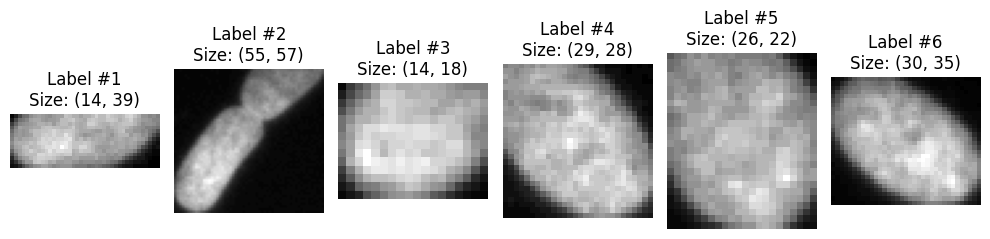

In [48]:
fig, axes = plt.subplots(1,6, figsize=(10,6))

for ii, obj_indices in enumerate(ndimage.find_objects(labels)[0:6]):
    cell = im_gray[obj_indices]
    axes[ii].imshow(cell, cmap='gray')
    axes[ii].axis('off')
    axes[ii].set_title('Label #{}\nSize: {}'.format(ii+1, cell.shape))

plt.tight_layout()
plt.show()

Label #2는 "인접한 세포" 문제가 있습니다: 두 개의 세포가 동일한 객체의 일부로 간주됩니다. 이 문제를 해결하기 위해 마스크를 축소하여 셀 간의 차이를 "열어볼" 수 있는지 확인할 수 있습니다. 이를 마스크 침식이라고 합니다. 그런 다음 원래 비율을 되돌리기 위해 다시 팽창시킬 수 있습니다.

In [53]:
two_cell_indices = ndimage.find_objects(labels)[1]  #2번 라벨
two_cell_indices #2번 라벨의 픽셀 위치

(slice(0, 55, None), slice(290, 347, None))

In [57]:
cell_mask = mask[two_cell_indices]
print(cell_mask.shape)
print(cell_mask)

(55, 57)
[[0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 0]
 [0 0 0 ... 1 1 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [55]:
cell_mask_opened = ndimage.binary_opening(cell_mask, iterations=8)
cell_mask_opened  #8번 반복해 나온 침식 결과

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

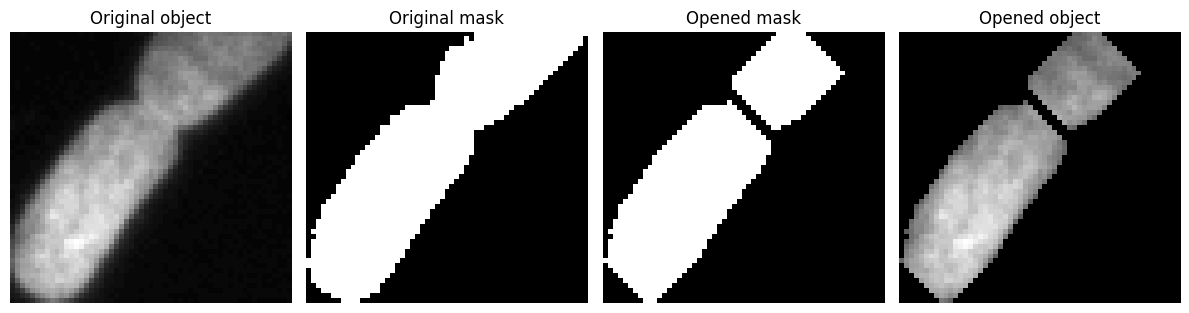

In [58]:
fig, axes = plt.subplots(1,4, figsize=(12,4))

axes[0].imshow(im_gray[two_cell_indices], cmap='gray')
axes[0].set_title('Original object')
axes[1].imshow(mask[two_cell_indices], cmap='gray')
axes[1].set_title('Original mask')
axes[2].imshow(cell_mask_opened, cmap='gray')
axes[2].set_title('Opened mask')
axes[3].imshow(im_gray[two_cell_indices]*cell_mask_opened, cmap='gray')
axes[3].set_title('Opened object')

#im_gray[two_cell_indices]: im_gray에서 two_cell_indices 이 부분 슬라이싱

for ax in axes:
    ax.axis('off')
plt.tight_layout()
plt.show()

### Convert each labeled object to Run Line Encoding(각 레이블된 객체를 런 라인 인코딩으로 변환)

기본적으로 배열을 탐색하고, 마스크에 속하는 픽셀을 찾으면 인덱싱하고, 그 다음 픽셀이 마스크의 일부인지를 계속해서 세어 나갑니다. 새로운 픽셀 시작점을 보게되면 이를 반복합니다.

저는 Kaggle 사용자 Rakhlin의 커널에서 좋은 RLE 함수를 찾았는데, 이를 여기에 복사해 두었습니다.


**결론) 이미지 데이터 제출을 위한 압축**

In [59]:
def rle_encoding(x):
    '''
    x: numpy array of shape (height, width), 1 - mask, 0 - background
    Returns run length as list
    '''
    dots = np.where(x.T.flatten()==1)[0] # .T sets Fortran order down-then-right
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b+1, 0))
        run_lengths[-1] += 1
        prev = b
    return " ".join([str(i) for i in run_lengths])

print('RLE Encoding for the current mask is: {}'.format(rle_encoding(label_mask)))

RLE Encoding for the current mask is: 210075 6 210593 8 211112 9 211631 10 212150 11 212669 12 213189 12 213709 12 214228 13 214748 13 215268 13 215788 13 216308 13 216828 13 217348 13 217869 12 218389 12 218909 12 219430 11 219950 11 220471 10 220991 10 221512 9 222033 8 222554 7 223075 6 223596 5 224117 4 224639 2


**RLE**

RLE 방식은 값이 같은 연속된 픽셀을 값과 연속된 개수로 표현하는 방식으로, 예를 들어 "aaabbcccccddee"의 RLE 인코딩 결과는 "3a2b5c2d2e"